In [1]:
import pandas as pd
import matplotlib.dates
import matplotlib.pyplot as plt
import numpy as np
import datetime, math

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

We then import the csv as a dataframe, because my (David Hadaller) laptop cannot handle importing 'mta_1708.csv', a 1.5 GB file, as Excel did in the cells above.

In [2]:
M100_NICK = pd.read_csv('M100_month_W125_st.csv')
M100_NICK.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime', 'time_delta', 'time_delta_mins', 'time_diff',
       'time_diff_mins'],
      dtype='object')

In [3]:
def ecdf(inputSeries,labelx,labely):
    try:
        x = np.sort(inputSeries)
    except:
        print("Warning: Series Unsorted")
        x = inputSeries
    y = np.arange(1, len(x)+1) / len(x)
    _ = plt.plot(x, y, marker='.', linestyle='none')
    _ = plt.xlabel(labelx)
    _ = plt.ylabel(labely)
    plt.margins(0.02) # Keeps data off plot edges
    plt.show()
    
def hist(inputSeries,labelx,labely):
    plt.hist(inputSeries, bins=25, density=True)
    _ = plt.xlabel(labelx)
    _ = plt.ylabel(labely)
    plt.show()

The charts below represent the ecdf and pdf of the bus average "time deltas" or time intervals between the departure of of one bus and the arrival of the next, over the course of the month of August in 2017. Also included are some acompanying summary statistics. Notice that, apart from a single outlier, these measurements do form some sort of distribution. Parameter estimation by bootstrapping could help us validate some hypotheses. Once we have a proper theoretical distribution to model this data, we can then use montecarlo metods to simluate passenger experience. So, what we've done is to derive the actual cdf (the dark blue line in the chart on the background information section), which means generating the biased cdf (the light blue line in the same background section) remains.

In [4]:
M100_NICK_Avg = M100_NICK[['RecordedAtTime','time_delta_mins']]
dates = M100_NICK_Avg['RecordedAtTime'].str.split(' ', 1, expand=True).drop([1],axis=1)
M100_NICK_Avg = pd.concat([dates,M100_NICK_Avg['time_delta_mins']],axis=1).rename(columns={0:'Date','time_delta_mins':'TimeDelta'})
M100_NICK_Avg = M100_NICK_Avg.groupby('Date').mean().dropna()
M100_NICK_Avg.head()

,TimeDelta
Date,
2017-08-01,59.545455
2017-08-02,487.666667
2017-08-03,155.500000
2017-08-04,62.750000
2017-08-05,716.500000


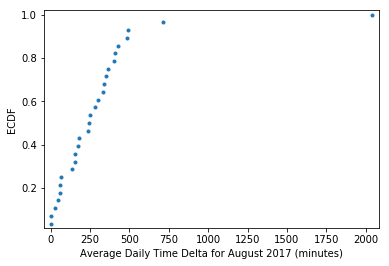

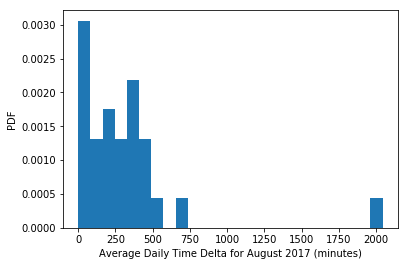

count      28.000000
mean      312.904996
std       380.947705
min         0.000000
25%       119.500000
50%       245.522222
75%       375.250000
max      2042.000000
Name: TimeDelta, dtype: float64

In [5]:
ecdf(M100_NICK_Avg['TimeDelta'],'Average Daily Time Delta for August 2017 (minutes)','ECDF')
hist(M100_NICK_Avg['TimeDelta'],'Average Daily Time Delta for August 2017 (minutes)','PDF')
M100_NICK_Avg['TimeDelta'].describe()

Below, we have also begun to plot time delta behavior for an individual day. 

* * *

What are my goals here? Ultimately, I want to have two plots
1. bus crowding (number of passengers per bus) against passenger arrival time for the month of August. 
2. A biased version of the ecdf at the end of `EDA-M100-A.ipynb`. Essentially, a plot of the The cumulative probability of the average daily bus crowding for each day in August.


**note to self:** what should I do about the very first bus ride for each day? It has no time delta because it has no bus precedes it. So how am I to measure crowding? 

Before we begin the simulation, we need to establish what will become the arguments to `numpy.random.uniform(low=0.0, high=1.0, size=None)`. Below, we find the `low` and `high` parameters. That is, we find the first and last bus arrival times for each day.

In [6]:
DailyBusMinMax= M100_NICK.loc[:,['RecordedAtTime']]
splitCol = DailyBusMinMax['RecordedAtTime'].str.split(' ', 1, expand=True).rename(columns={0:'Date', 1:'Time'}) 
DailyBusMinMax['Date']= splitCol['Date'] 

DailyBusMinMax = DailyBusMinMax.drop_duplicates()

DailyBusMax = DailyBusMinMax.groupby('Date').max()
DailyBusMin = DailyBusMinMax.groupby('Date').min()

DailyBusMinMax = pd.merge(left=DailyBusMin, right=DailyBusMax, how='inner',on='Date', suffixes=('Min', 'Max'))
DailyBusMinMax = DailyBusMinMax.rename(columns={'RecordedAtTimeMin':'EarliestBusArrival', 'RecordedAtTimeMax':'LatestBusArrival'})

DailyBusMinMax.reset_index(level=0, inplace=True)
DailyBusMinMax['Date'] = pd.to_datetime(DailyBusMinMax['Date'],format='%Y-%m-%d')
DailyBusMinMax['EarliestBusArrival'] = pd.to_datetime(DailyBusMinMax['EarliestBusArrival'], format='%Y-%m-%d %H:%M:%S')
DailyBusMinMax['LatestBusArrival'] = pd.to_datetime(DailyBusMinMax['LatestBusArrival'], format='%Y-%m-%d %H:%M:%S')

DailyBusMinMax.head()

,Date,EarliestBusArrival,LatestBusArrival
0,2017-08-01,2017-08-01 07:51:49,2017-08-01 18:42:04
1,2017-08-02,2017-08-02 15:54:31,2017-08-02 19:14:42
2,2017-08-03,2017-08-03 13:06:46,2017-08-03 18:17:14
3,2017-08-04,2017-08-04 11:28:26,2017-08-04 21:48:55
4,2017-08-05,2017-08-05 15:10:31,2017-08-05 21:40:50


In the cell below, we take the bus arrival times (when the bus pulls into the stop), the dates associated with each bus arrival time (to help with subsequent merges) and the timedeltas (which we may plot later on) from the original `M100_NICK` data

In [7]:
BusArrivals = M100_NICK.loc[:,['RecordedAtTime','time_delta_mins']]
dates = M100_NICK['RecordedAtTime'].str.split(' ', 1, expand=True).rename(columns={0:'Date'})
BusArrivals.insert(loc=0, column='Date', value=dates['Date'])

BusArrivals = BusArrivals.rename(columns={'RecordedAtTime':'BusArrivalTime'})

# Change Column DataTypes from String (object) to DateTime
BusArrivals['BusArrivalTime'] = pd.to_datetime(BusArrivals['BusArrivalTime'], format='%Y-%m-%d %H:%M:%S')
BusArrivals['Date'] = pd.to_datetime(BusArrivals['Date'], format='%Y-%m-%d %H:%M:%S')
BusArrivals = BusArrivals.drop_duplicates()

BusArrivals.head()

,Date,BusArrivalTime,time_delta_mins
0,2017-08-01,2017-08-01 07:51:49,0
3,2017-08-01,2017-08-01 11:02:25,191
4,2017-08-01,2017-08-01 13:42:23,161
5,2017-08-01,2017-08-01 13:52:39,10
6,2017-08-01,2017-08-01 15:53:02,121


Next, we define a simulation function which gets the `low` and `high` bounds of the uniform distribution from the DailyBusMinMax dataframe and then takes `NumPassengers` for population size of passengers to simulate. 

This simulation function creates a "pivot table" with the Date as pseudo-index and an artificial passengerId for column headers. For each date, the table contains each passenger in NumPassengers simulated bus arrival time (the time at which each passenger approaches the bus stop with the hopes of boarding a bus.)

Of course, the table that results isn't a true pivot table, because the Date column is just another column, rather than a pandas index. Keeping the Date as a column allows us to reference it as a column later on, which will come in handy when we need to return a series of dates.

In [8]:
def passengerSim(DailyBusMinMax, NumPassengers):
    
    #time between the first and last bus arrivals
    dailyDelta = DailyBusMinMax['LatestBusArrival'] - DailyBusMinMax['EarliestBusArrival']
    
    # the first bus arrival
    dailyMin = DailyBusMinMax['EarliestBusArrival']
    
    #number of dates to simulate for
    NumDates = len(DailyBusMinMax.Date)
    
    #this vectorized calculation follows the formula dailyDelta * randomVar + firstBusArrival to choose a random time
        # between the EarliestBusArrival and the LatestBusArrival.
        # this is done for every date and for each passenger in NumPassengers
    pSim = pd.DataFrame(np.random.uniform(0,1,(NumDates,NumPassengers)))
    pSim = pSim.mul(dailyDelta,axis=0)
    pSim = pSim.add(dailyMin,axis=0)
    
    # add a dates column to front of dataframe  
    pSim.insert(loc=0, column='Date', value=DailyBusMinMax['Date'])
    
    return pSim

In [16]:
sim = passengerSim(DailyBusMinMax,1000)
sim.head()

,Date,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,2017-08-01,2017-08-01 14:58:30.962560979,2017-08-01 12:28:59.222934784,2017-08-01 17:49:35.518881902,2017-08-01 08:37:11.438974009,2017-08-01 08:42:00.795142162,2017-08-01 07:55:13.733792059,2017-08-01 13:12:05.445121825,2017-08-01 12:43:57.395044691,2017-08-01 13:11:00.676424257,...,2017-08-01 18:15:24.636667439,2017-08-01 16:19:07.352396958,2017-08-01 18:19:56.424429435,2017-08-01 12:50:13.267366644,2017-08-01 09:33:13.071630876,2017-08-01 08:06:16.059527159,2017-08-01 18:04:19.486241378,2017-08-01 15:38:16.903280625,2017-08-01 14:39:50.013121752,2017-08-01 11:05:51.864103207
1,2017-08-02,2017-08-02 18:59:50.331549384,2017-08-02 19:03:51.530744734,2017-08-02 18:21:18.806340529,2017-08-02 17:22:18.987310266,2017-08-02 19:04:57.899572034,2017-08-02 18:11:06.029193441,2017-08-02 19:05:30.163949976,2017-08-02 15:56:09.561140503,2017-08-02 17:14:28.914202896,...,2017-08-02 17:49:34.095730022,2017-08-02 18:40:44.790037289,2017-08-02 16:17:31.153468836,2017-08-02 18:58:22.620178921,2017-08-02 18:00:37.280138082,2017-08-02 16:18:45.988536925,2017-08-02 17:35:22.458659309,2017-08-02 18:13:40.637746641,2017-08-02 15:58:55.174814876,2017-08-02 16:58:58.639110599
2,2017-08-03,2017-08-03 18:00:13.030232064,2017-08-03 13:21:57.322475785,2017-08-03 14:18:54.514986343,2017-08-03 14:33:39.452274853,2017-08-03 16:26:44.431719245,2017-08-03 16:56:50.510550070,2017-08-03 14:53:25.864323503,2017-08-03 17:39:44.432162632,2017-08-03 16:11:32.069630261,...,2017-08-03 14:01:54.917312962,2017-08-03 14:09:31.980654797,2017-08-03 17:44:05.991754076,2017-08-03 13:08:28.582797071,2017-08-03 14:21:50.652134617,2017-08-03 13:27:01.414058866,2017-08-03 16:55:30.016363785,2017-08-03 14:52:18.034223178,2017-08-03 16:37:25.119366545,2017-08-03 17:26:04.286118954
3,2017-08-04,2017-08-04 15:55:54.303516126,2017-08-04 17:36:26.024335894,2017-08-04 15:21:22.453538779,2017-08-04 15:03:46.144363339,2017-08-04 13:50:18.425903958,2017-08-04 17:07:10.813490160,2017-08-04 21:32:31.611906635,2017-08-04 13:18:32.762883274,2017-08-04 13:10:29.938721978,...,2017-08-04 21:00:13.589041092,2017-08-04 17:55:11.306591294,2017-08-04 14:07:27.626246316,2017-08-04 14:35:57.216241049,2017-08-04 21:31:22.368043933,2017-08-04 19:22:19.733529552,2017-08-04 21:34:37.184518534,2017-08-04 19:05:24.581463191,2017-08-04 21:22:31.380031790,2017-08-04 13:47:29.736262873
4,2017-08-05,2017-08-05 15:57:01.853284683,2017-08-05 20:02:44.011482512,2017-08-05 18:39:55.706341426,2017-08-05 17:33:54.598224102,2017-08-05 19:59:20.370992147,2017-08-05 16:14:40.974734108,2017-08-05 16:19:50.683422831,2017-08-05 19:18:55.850989800,2017-08-05 17:21:39.470637486,...,2017-08-05 16:30:12.132450937,2017-08-05 16:01:03.220956911,2017-08-05 17:17:42.012686554,2017-08-05 18:41:37.295908197,2017-08-05 16:50:08.185159718,2017-08-05 16:08:27.689298165,2017-08-05 18:05:19.524765979,2017-08-05 19:11:47.305885265,2017-08-05 17:44:32.791760653,2017-08-05 18:24:33.520258314


Here, we reorganize the results of the passenger simulation to get a table that has one single `passengerId` column, instead of one column for each passenger. This is will allow us to perform a merge in the following step.

In [10]:
sim = sim.melt(id_vars='Date')
sim = sim.rename(columns={'variable':'passengerId','value':'passengerArrivalTime'})
sim.head()

,Date,passengerId,passengerArrivalTime
0,2017-08-01,0,2017-08-01 11:39:39.549740635
1,2017-08-02,0,2017-08-02 16:19:10.192981929
2,2017-08-03,0,2017-08-03 15:37:14.138344618
3,2017-08-04,0,2017-08-04 17:18:40.567291197
4,2017-08-05,0,2017-08-05 21:40:45.029898030


As promised, we now merge the passenger simulation,`sim` with the bus arrival times, `BusArrivals`. The result of the code below is a lookup table where each passenger arrival time is associated with one bus arrival time; that is to say, the passengers are associated with the bus they board (which will always be the next bus that approaches the stop after they arrive.)

In [15]:
# The powerset of all passenger-bus combinations
busBoarding = pd.merge(right=sim, left=BusArrivals, on='Date', how='inner')

# whittle down previous dataframe to those where passengers board busses that arrive at stop after they do
    # (no going back in time)
busBoarding = busBoarding.loc[busBoarding['BusArrivalTime']>=busBoarding['passengerArrivalTime']]

# the passenger is reasonable and will board the first bus that approaches the stop
busBoarding = busBoarding.groupby(['Date','passengerId','passengerArrivalTime']).first()

# we reset the index to group by a different column in the next step
busBoarding = busBoarding.reset_index().sort_values(['Date','BusArrivalTime','passengerId'])
busBoarding.head()

,Date,passengerId,passengerArrivalTime,BusArrivalTime,time_delta_mins
2,2017-08-01,2,2017-08-01 08:11:56.770995441,2017-08-01 11:02:25,191
4,2017-08-01,4,2017-08-01 10:10:16.702411667,2017-08-01 11:02:25,191
7,2017-08-01,7,2017-08-01 08:01:31.465772407,2017-08-01 11:02:25,191
15,2017-08-01,15,2017-08-01 09:51:01.676857761,2017-08-01 11:02:25,191
18,2017-08-01,18,2017-08-01 07:53:50.644836133,2017-08-01 11:02:25,191


Now, we calcuate the number of people per bus by grouping by `BusArrivalTime` and then counting the number of entries in each group. We then merge this `busCrowding` DataFrame back into our `busBoarding` DataFrame from the previous step to give us a `numPassengersPerBus` column, which tells us exactly how many of our simulated passengers boarded each bus.

In [12]:
busCrowding = busBoarding.groupby(['BusArrivalTime']).count()
busCrowding = pd.DataFrame(busCrowding['passengerId']).rename(columns={'passengerId':'numPassengersPerBus'})
busCrowding.reset_index()

busBoarding = pd.merge(left=busBoarding, right=busCrowding, on='BusArrivalTime', how='inner')
busBoarding.head()


,Date,passengerId,passengerArrivalTime,BusArrivalTime,time_delta_mins,numPassengersPerBus
0,2017-08-01,2,2017-08-01 08:11:56.770995441,2017-08-01 11:02:25,191,319
1,2017-08-01,4,2017-08-01 10:10:16.702411667,2017-08-01 11:02:25,191,319
2,2017-08-01,7,2017-08-01 08:01:31.465772407,2017-08-01 11:02:25,191,319
3,2017-08-01,15,2017-08-01 09:51:01.676857761,2017-08-01 11:02:25,191,319
4,2017-08-01,18,2017-08-01 07:53:50.644836133,2017-08-01 11:02:25,191,319


We now take a few columns of the `busBoarding`data that to plot the relationship between `passengerArrivalTime` and `numPassengersPerBus`.

In [13]:
plotData = busBoarding.loc[:,['passengerArrivalTime','numPassengersPerBus']]
plotData['passengerArrivalTime'] = plotData.passengerArrivalTime.dt.time
plotData.head()

,passengerArrivalTime,numPassengersPerBus
0,08:11:56.770995,319
1,10:10:16.702411,319
2,08:01:31.465772,319
3,09:51:01.676857,319
4,07:53:50.644836,319


Finally, we have our plot.

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.,  80000.,  90000.]),
 <a list of 11 Text xticklabel objects>)

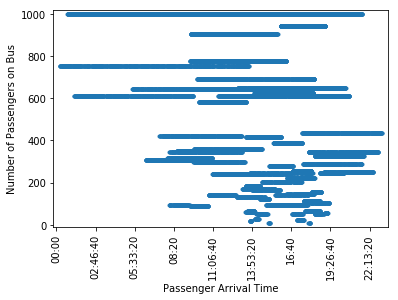

In [14]:
plotData = plotData.sort_values('passengerArrivalTime', ascending=True)
_= plt.plot(plotData['passengerArrivalTime'], plotData['numPassengersPerBus'],'.',linestyle='none')
_ = plt.xlabel('Passenger Arrival Time')
_ = plt.ylabel('Number of Passengers on Bus')
_ = plt.margins(0.02) # Keeps data off plot edges
plt.xticks(rotation='vertical')

Notice that the above plot features a series of points a the 1000 people mark. This signifies that there are busses so crowded that they fit 1000 passengers inside. Clearly there is an innacuracy in the data. The source of the problem is that there is only one bus per day on some days, but the daily population of passengers remains 1000 every day. So far as we can see, there can be two causes for this error: 

1. Some of the bus arrival data is being unnecessarily deleted or is missing; there are no "one-bus-only" days at this stop.
2. The number of passengers should be adapted to the number of busses for each transit day. This would mean the error was setting the daily ridership at a constant of `numPassengers=1000`.

However, once find the source of this error, we will have our "base truth" to help train our models on in the next phase of our project. 